# Precios Vivienda

La base de datos contiene información principalmente sobre el área de construcción y la ubicación geográfica de los inmuebles, pero carece de variables relevantes para un análisis valuatorio más preciso, como la edad, el estado de conservación, el tamaño del terreno o la ubicación dentro de la manzana (esquina, interior, dos frentes, etc.). No obstante, el alcance de este trabajo se centra en analizar el precio de la vivienda en la Ciudad de México utilizando exclusivamente el área de construcción y la ubicación geográfica, con el objetivo de evaluar el impacto que estas variables tienen en la predicción general del precio.

## Preparación de Base de Datos

In [11]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [13]:
# Base de datos
df1 = pd.read_csv('C:/Users/rg_jm/OneDrive/Proyectos Ciencia de Datos/Vivienda/mexico-city-real-estate-1.csv')
df2 = pd.read_csv('C:/Users/rg_jm/OneDrive/Proyectos Ciencia de Datos/Vivienda/mexico-city-real-estate-2.csv')
df3 = pd.read_csv('C:/Users/rg_jm/OneDrive/Proyectos Ciencia de Datos/Vivienda/mexico-city-real-estate-3.csv')
df4 = pd.read_csv('C:/Users/rg_jm/OneDrive/Proyectos Ciencia de Datos/Vivienda/mexico-city-real-estate-4.csv')
df5 = pd.read_csv('C:/Users/rg_jm/OneDrive/Proyectos Ciencia de Datos/Vivienda/mexico-city-real-estate-5.csv')

# Unificar base de datos en una
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.head(4)

operation property_type                   place_with_parent_names  \
0      sell     apartment  |Miguel Hidalgo|Distrito Federal|México|   
1      sell         house      |Iztapalapa|Distrito Federal|México|   
2      sell     apartment         |Tlalpan|Distrito Federal|México|   
3      sell     apartment  |Miguel Hidalgo|Distrito Federal|México|   

                 lat-lon      price currency  price_aprox_local_currency  \
0  23.634501,-102.552788  5500000.0      MXN                  5450245.50   
1    19.31033,-99.068557  1512000.0      MXN                  1498321.97   
2   19.279771,-99.234597   926667.0      MXN                   918284.00   
3  23.634501,-102.552788  6410000.0      MXN                  6352013.39   

   price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
0        289775.66                  NaN                   54.0   
1         79661.96                  NaN                   80.0   
2         48822.82                  NaN                  100.0   
3        337720.36                  NaN                  135.0   

   price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
0               NaN  101851.85190    NaN    NaN       NaN   
1               NaN   18900.00000    NaN    NaN       NaN   
2               NaN    9266.67000    NaN    NaN       NaN   
3               NaN   47481.48148    NaN    NaN       NaN   

                                       properati_url  
0  http://miguel-hidalgo-df.properati.com.mx/o3zb...  
1  http://iztapalapa.properati.com.mx/q7t0_venta_...  
2  http://tlalpan.properati.com.mx/qbi4_venta_dep...  
3  http://miguel-hidalgo-df.properati.com.mx/opeq...

In [15]:
# Se separa 'lat-lon' en dos variables
coordenadas = df['lat-lon'].str.split(',', expand=True)
coordenadas.columns = ['latitud', 'longitud']

# Convertir a tipo numérico (float)
coordenadas['latitud'] = pd.to_numeric(coordenadas['latitud'], errors='coerce')
coordenadas['longitud'] = pd.to_numeric(coordenadas['longitud'], errors='coerce')
coordenadas.head()

latitud    longitud
0  23.634501 -102.552788
1  19.310330  -99.068557
2  19.279771  -99.234597
3  23.634501 -102.552788
4  21.190264  -86.819838

In [17]:
# Se separa la ubicación en Variables: Localidad, Municipio y Estado

lugar = df['place_with_parent_names'].str.split('|', expand=True) 

# Se organizan los valores en su columna correspondiente
mask = lugar[4] == 'México'
lugar['Localidad'] = np.where(mask, lugar[1], lugar[0])
lugar['Municipio'] = np.where(mask, lugar[2], lugar[1])
lugar['Estado'] = np.where(mask, lugar[3], lugar[2])

# Se elimina las columnas innecesarias
lugar = lugar.drop(range(6), axis = 1)
lugar.head()

Localidad       Municipio            Estado
0            Miguel Hidalgo  Distrito Federal
1                Iztapalapa  Distrito Federal
2                   Tlalpan  Distrito Federal
3            Miguel Hidalgo  Distrito Federal
4             Benito Juárez      Quintana Roo

In [19]:
# Se determina la superficie construida correcta
construccion_m2 = np.where(
    df['surface_covered_in_m2'].notna() & (df['surface_covered_in_m2'] != 0),
    df['surface_covered_in_m2'],
    np.where(
        df['price_per_m2'].notna() & (df['price_per_m2'] != 0),
        df['price_aprox_local_currency'] / df['price_per_m2'],
        df['price_aprox_usd'] / df['price_usd_per_m2']
    )
)
construccion_m2 = pd.DataFrame(construccion_m2)
construccion_m2.columns = ["m2"]
construccion_m2.head()

m2
0   54.0
1   80.0
2  100.0
3  135.0
4  263.0

In [25]:
# Se calcula el precio por m2
precio_m2 = df['price_aprox_local_currency'] / construccion_m2['m2']
precio_m2 = pd.DataFrame(precio_m2, columns = ['precio m2'])
precio_m2.head()

precio m2
0  100930.472222
1   18729.024625
2    9182.840000
3   47051.951037
4   62575.807985

In [29]:
df_limpia = pd.concat([
    df['price_aprox_local_currency'], 
    precio_m2, 
    construccion_m2, 
    coordenadas, 
    lugar[['Municipio','Estado']],
    df['property_type']
], axis=1)

df_limpia.columns = ['precio', 'precio_m2', 'construccion_m2', 'latitud', 'longitud', 'municipio', 'estado','tipo']
df_limpia.head()

precio      precio_m2  construccion_m2    latitud    longitud  \
0   5450245.50  100930.472222             54.0  23.634501 -102.552788   
1   1498321.97   18729.024625             80.0  19.310330  -99.068557   
2    918284.00    9182.840000            100.0  19.279771  -99.234597   
3   6352013.39   47051.951037            135.0  23.634501 -102.552788   
4  16457437.50   62575.807985            263.0  21.190264  -86.819838   

        municipio            estado       tipo  
0  Miguel Hidalgo  Distrito Federal  apartment  
1      Iztapalapa  Distrito Federal      house  
2         Tlalpan  Distrito Federal  apartment  
3  Miguel Hidalgo  Distrito Federal  apartment  
4   Benito Juárez      Quintana Roo  apartment

In [31]:
# Función para calcular datos faltantes en cada columna y filas duplicadas
def missing(df):
    print("Datos faltantes:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valores_faltantes': missing,
        'Porcentaje': missing_percent
    })
    print(missing_df[missing_df['Valores_faltantes'] > 0])
    
    # Duplicados
    print(f"\nFilas duplicadas: {df.duplicated().sum()}")

In [35]:
missing(df_limpia)  # Datos faltantes

Datos faltantes:
                 Valores_faltantes  Porcentaje
precio                         395    1.707001
precio_m2                     1015    4.386344
construccion_m2                951    4.109767
latitud                       2442   10.553155
longitud                      2442   10.553155

Filas duplicadas: 3183


In [37]:
# Se determinan las variables latitud y longitud de un caso particular en Milpa Alta, México
df_limpia.iloc[10851,3] = 19.185852
df_limpia.iloc[10851,4] = -99.076461

# Se eliminan las filas duplicadas
df_limpia = df_limpia.drop_duplicates()

# Se eliminan las filas con información incompleta
df_limpia = df_limpia.dropna()

In [39]:
# Se verifica si existen datos faltantes o duplicados
missing(df_limpia)

Datos faltantes:
Empty DataFrame
Columns: [Valores_faltantes, Porcentaje]
Index: []

Filas duplicadas: 0


In [49]:
# Se detectaron inconsistencias entre el municipio o alcaldía y la ubicación UTM. Hay latitudes y longitudes fuera del rango del municipio.
# Se procede a depurar estos errores.
q_roo_invalido = (df_limpia.estado == 'Quintana Roo') & (df_limpia.latitud > 22)
zacatecas_invalido = (df_limpia.estado == 'Zacatecas') & (df_limpia.latitud < 19)
cdmx_invalido = (df_limpia.estado == 'Distrito Federal') & ((df_limpia.longitud < -100) | (df_limpia.longitud > -98))
invalido = q_roo_invalido | zacatecas_invalido | cdmx_invalido

df_limpia = df_limpia[ -invalido ]

In [51]:
# Resumen estadístico de las variables numéricas
df_limpia.describe()

precio     precio_m2  construccion_m2       latitud      longitud
count  1.696600e+04  1.696600e+04     1.696600e+04  16966.000000  16966.000000
mean   5.484720e+06  3.764202e+04     4.544831e+03     19.699458    -96.800205
std    1.079448e+07  7.055854e+05     5.057017e+05      0.681739      4.856601
min    1.090306e+05  1.127653e-02     1.000000e+00     18.348334   -116.602432
25%    1.163960e+06  1.230967e+04     7.000000e+01     19.360840    -99.187081
50%    2.526932e+06  1.943415e+04     1.100000e+02     19.400524    -99.148773
75%    5.176965e+06  3.498106e+04     2.250000e+02     19.474269    -99.078728
max    3.776868e+08  6.582975e+07     6.574800e+07     31.870501    -86.729692

In [53]:
# Función para contar valores de cada columna no numérica
def conteo(df):
    for col in df.select_dtypes(exclude=['number']).columns:
        print(f'{df[col].value_counts()} \n')

In [55]:
# Resumen de las variables no numéricas
conteo(df_limpia)

municipio
Benito Juárez             4707
Álvaro Obregón            1664
Cuauhtémoc                1638
Miguel Hidalgo            1574
Solidaridad               1113
Coyoacán                  1037
Tlalpan                    835
Gustavo A. Madero          785
Iztapalapa                 744
Cuajimalpa de Morelos      536
Azcapotzalco               522
Venustiano Carranza        506
Iztacalco                  348
La Magdalena Contreras     251
Tláhuac                    218
Xochimilco                 200
Tulum                      134
Tabasco                     43
Cozumel                     31
Othón P. Blanco             28
Zacatecas                   19
Fresnillo                    9
Isla Mujeres                 6
Bacalar                      5
Villanueva                   3
Calera                       2
Milpa Alta                   2
Mexicali                     2
Río Grande                   2
Felipe Carrillo Puerto       1
Lázaro Cárdenas              1
Name: count, dtype: int64 

e

In [59]:
# Data frame limpio
df_limpia.head(10)

precio     precio_m2  construccion_m2    latitud   longitud  \
1    1498321.97  18729.024625             80.0  19.310330 -99.068557   
2     918284.00   9182.840000            100.0  19.279771 -99.234597   
4   16457437.50  62575.807985            263.0  21.190264 -86.819838   
5    4376051.62  50299.443908             87.0  19.432657 -99.177444   
6    3122244.47  31222.444700            100.0  19.367025 -99.170349   
7    2067789.37  10086.777415            205.0  19.340909 -99.225110   
8    1585525.89  11010.596458            144.0  19.509359 -99.093272   
9    6441199.16  18403.426171            350.0  21.119158 -86.846930   
10   4359347.04  14339.957368            304.0  19.432901 -99.213075   
12   5642550.00  35265.937500            160.0  20.498783 -87.222819   

            municipio            estado       tipo  
1          Iztapalapa  Distrito Federal      house  
2             Tlalpan  Distrito Federal  apartment  
4       Benito Juárez      Quintana Roo  apartment  
5      Miguel Hidalgo  Distrito Federal  apartment  
6       Benito Juárez  Distrito Federal  apartment  
7      Álvaro Obregón  Distrito Federal      house  
8   Gustavo A. Madero  Distrito Federal      house  
9       Benito Juárez      Quintana Roo      house  
10     Miguel Hidalgo  Distrito Federal      house  
12        Solidaridad      Quintana Roo  apartment

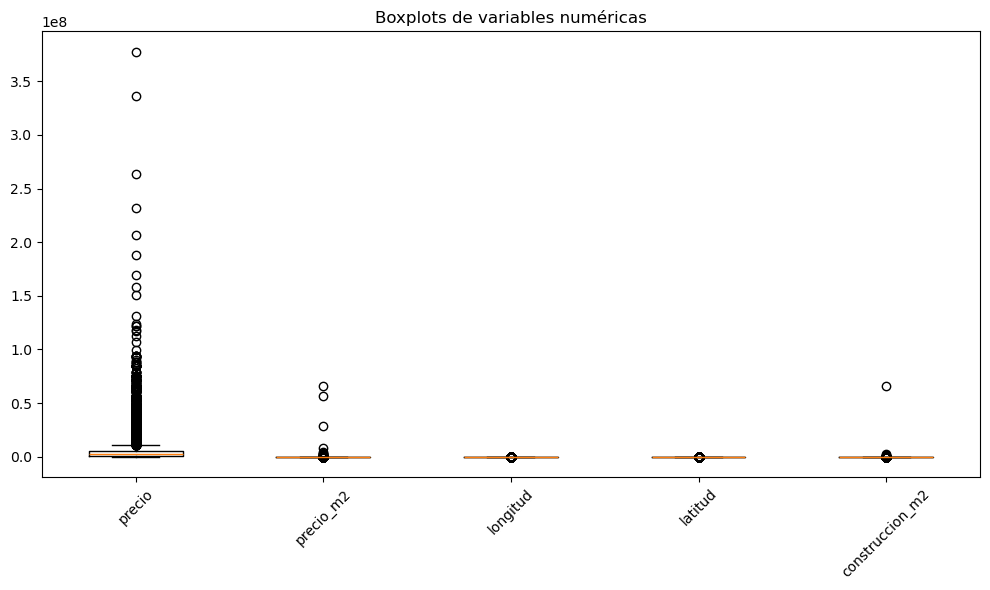

In [67]:
# Datos de variables numéricas
col_num = ['precio', 'precio_m2', 'longitud', 'latitud', 'construccion_m2']
df_limpia_num = [df_limpia[col].dropna() for col in col_num]

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df_limpia_num, tick_labels=col_num, showfliers=True)
plt.xticks(rotation=45)
plt.title("Boxplots de variables numéricas")
plt.tight_layout()
plt.show()

    # NOTA: Existe mucha dispersión y valores atípicos en la variable precio, pero no se mantendrán hasta el análisis particular de cada estado

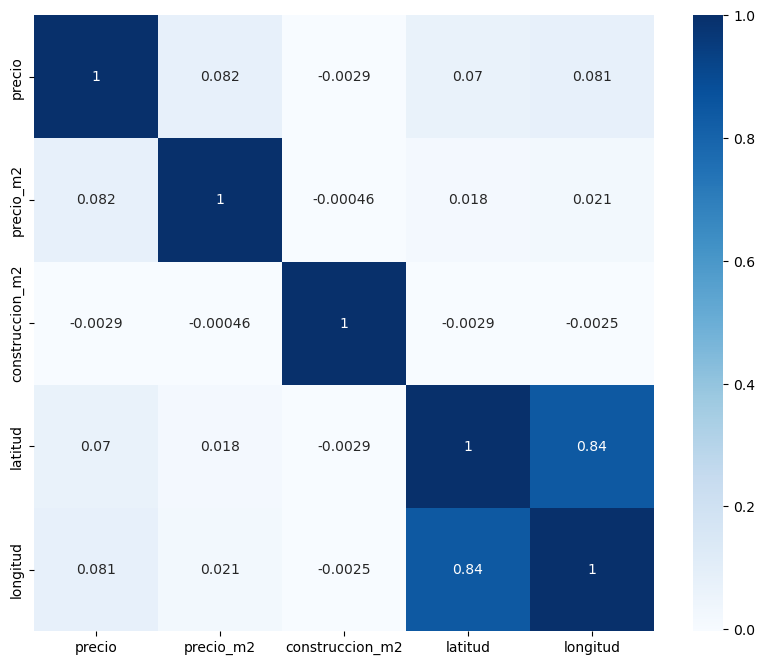

In [50]:
df_sin_col = df_limpia.drop(['municipio','estado','tipo'], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(df_sin_col.corr(), annot=True, cmap='Blues');

In [51]:
# sns.pairplot(df_sin_col);

## Análisis CDMX

Se inicia este análisis obteniendo un subconjunto de la base de datos principal, para enfocarse únicamente en el género de Vivienda Unifamiliar dentro de la Ciudad de México.

In [91]:
# Se selecciona un lugar y un tipo de edificio
data = df_limpia[(df_limpia.estado == 'Distrito Federal') & (df_limpia.tipo == 'house')].copy()
data.columns = ['precio', 'precio_m2', 'construccion_m2', 'latitud', 'longitud','alcaldia', 'estado', 'tipo']
data.head()

precio     precio_m2  construccion_m2    latitud   longitud  \
1   1498321.97  18729.024625             80.0  19.310330 -99.068557   
7   2067789.37  10086.777415            205.0  19.340909 -99.225110   
8   1585525.89  11010.596458            144.0  19.509359 -99.093272   
10  4359347.04  14339.957368            304.0  19.432901 -99.213075   
16  4845723.38   9142.874302            530.0  19.452952 -99.158166   

             alcaldia            estado   tipo  
1          Iztapalapa  Distrito Federal  house  
7      Álvaro Obregón  Distrito Federal  house  
8   Gustavo A. Madero  Distrito Federal  house  
10     Miguel Hidalgo  Distrito Federal  house  
16         Cuauhtémoc  Distrito Federal  house

In [93]:
# Función para convertir a variables categóricas las variables no numéricas
def categoria(df):
    for col in df.columns:
        if df[col].dtype=='O':
            df[col] = df[col].astype('category')

# Función para eliminar datos atípicos de una variable de un dataframe 
def filtrar_iqr(df, col, k=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return df[(df[col] >= low) & (df[col] <= high)]

In [95]:
# Se convierten las variables no numéricas a variables categóricas
categoria(data)

# Se eliminan los datos atípicos
data = filtrar_iqr(data, 'construccion_m2')
data = filtrar_iqr(data, 'precio_m2')

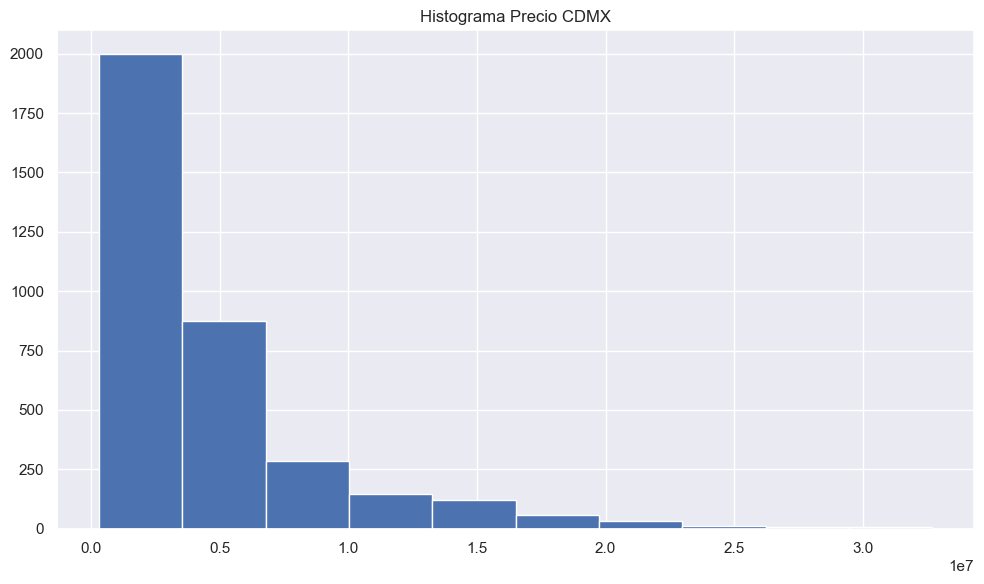

In [143]:
# Histograma Precios CDMX
plt.figure(figsize=(10, 6))
plt.hist(data.precio)
plt.title("Histograma Precio CDMX")
plt.tight_layout()
plt.show()

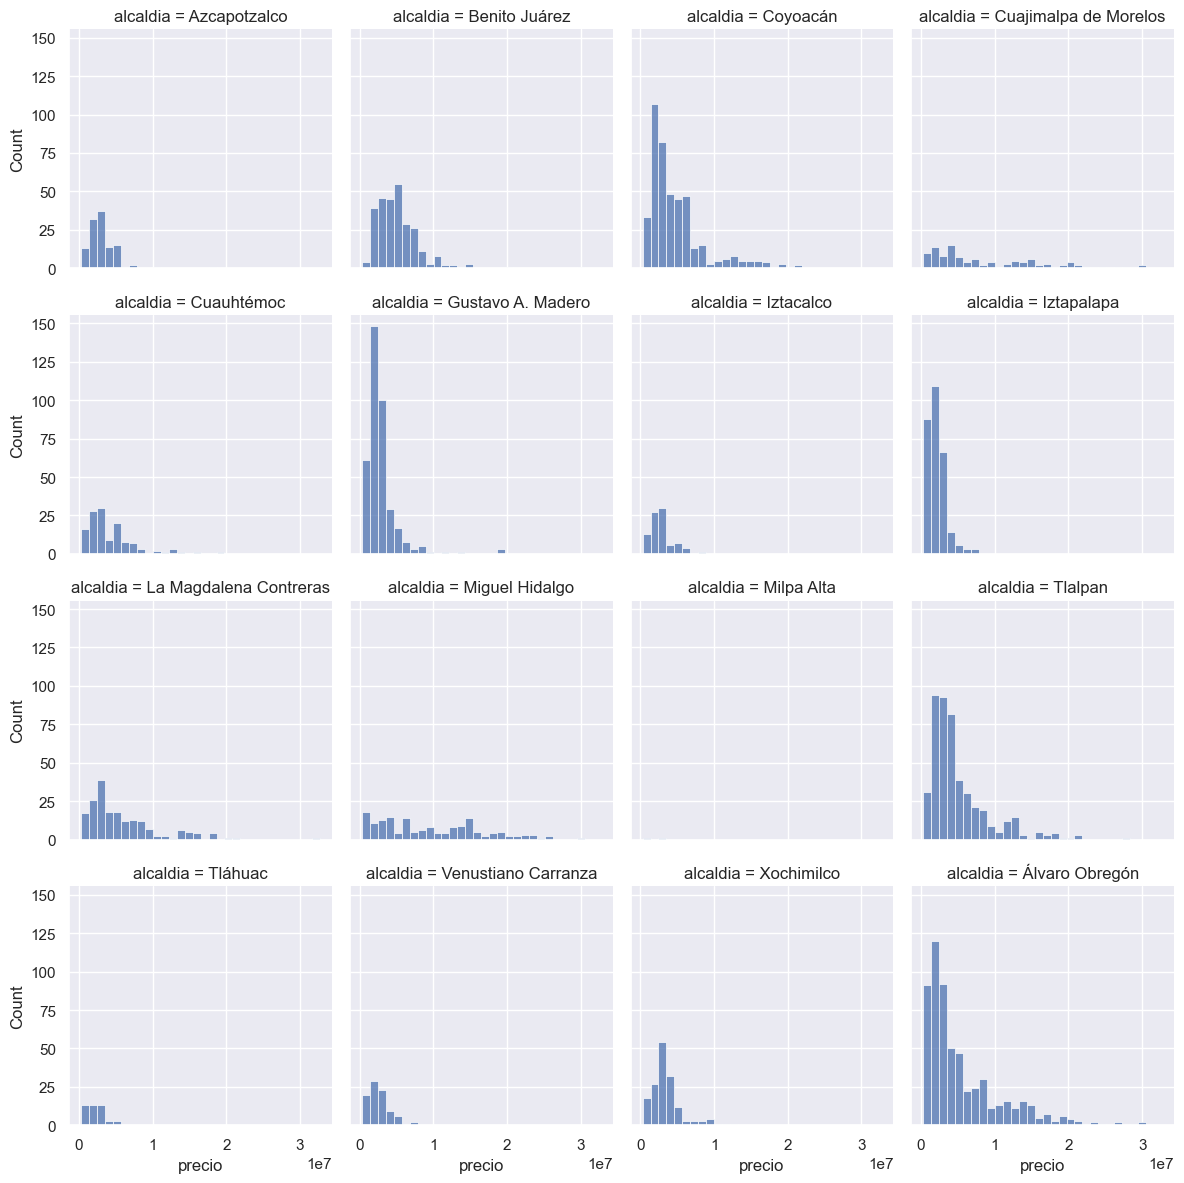

In [169]:
# Histograma por Alcaldía
sns.set_theme(style="darkgrid")

sns.displot(
    data=data,
    x="precio",
    col="alcaldia",
    col_wrap=4,
    bins=30,
    height=3,
    facet_kws=dict(margin_titles=True)
)

plt.show()

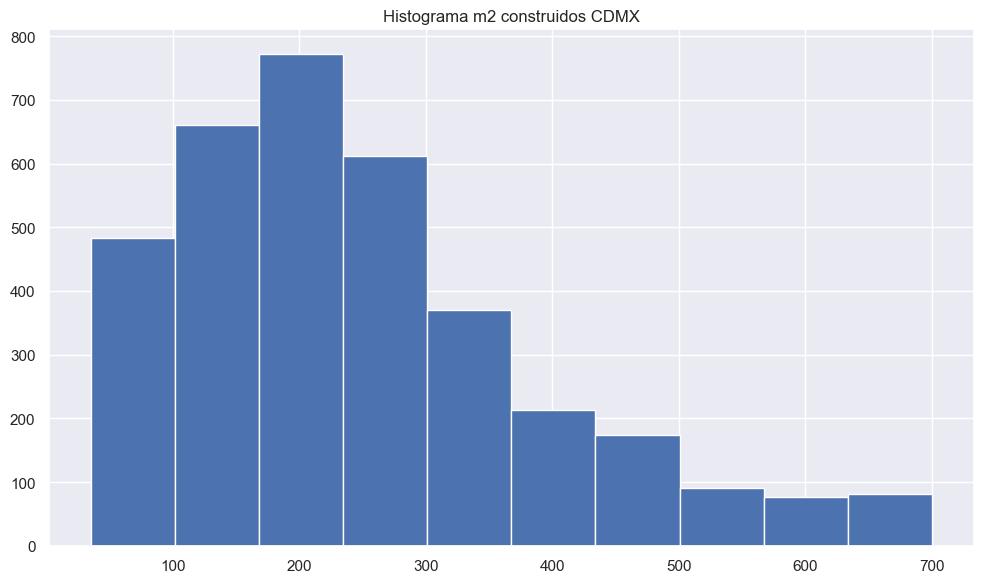

In [171]:
# Histograma m2 construidos
plt.figure(figsize=(10, 6))
plt.hist(data.construccion_m2)
plt.title("Histograma m2 construidos CDMX")
plt.tight_layout()
plt.show()

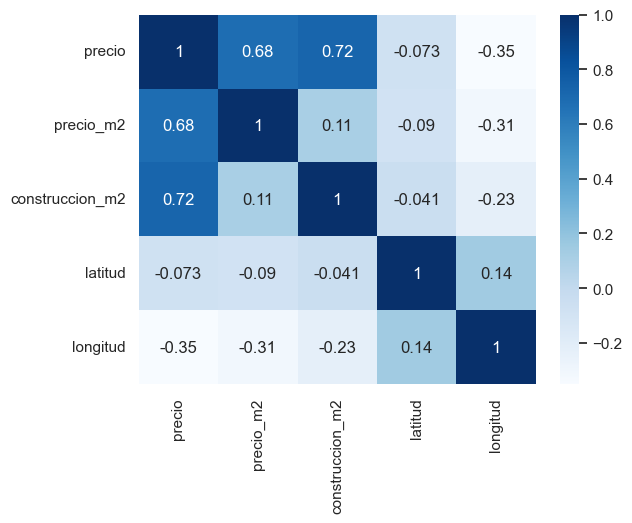

In [127]:
df_sin_col = data.drop(['alcaldia','estado','tipo'], axis=1)
plt.figure()
sns.heatmap(df_sin_col.corr(), annot=True, cmap='Blues')
plt.show()

El análisis revela una fuerte correlación positiva entre el precio de un inmueble y su área construida, confirmando la regla básica de que, a mayor tamaño, mayor valor.

Además, la distribución de precios no es simétrica. El histograma muestra una cola pesada hacia la derecha, lo que indica que, si bien la mayoría de las propiedades se concentran en un rango de precios, existe un grupo significativo de inmuebles con valores excepcionalmente altos. Esta asimetría es la razón por la cual se eligió un modelo estadístico Gamma, que es ideal para modelar datos positivos y con esta forma de distribución.

## Modelo Lineal Generalizado (GLM)

Un Modelo Lineal Generalizado (GLM) extiende la regresión lineal clásica permitiendo modelar variables respuesta cuya distribución no es normal y cuya varianza depende del nivel de la media.

Formalmente, un GLM se define por tres componentes:

**Componente aleatorio**
Se asume que $Y|X$ sigue una distribución de la familia exponencial. En valuación inmobiliaria, el precio suele modelarse con una Gamma, ya que es continuo, positivo y asimétrico.

**Componente sistemático**
La media condicional $\mu=E(Y∣X)$ se expresa como una combinación lineal de las variables explicativas:
$$\eta = X \beta$$

**Función de enlace**
Conecta la media con el predictor lineal:
$$g(\mu)=\eta$$

En este caso, se usa un enlace log, lo que garantiza predicciones positivas y permite interpretar los coeficientes como efectos porcentuales.


En un GLM Gamma con enlace log, la varianza cumple:
$$Var(Y∣X)= \theta \mu^2$$

lo que refleja que la incertidumbre crece proporcionalmente al nivel del precio, una propiedad consistente con el mercado inmobiliario.

### Entrenamiento

Se realizaron múltiples pruebas de entrenamiento; sin embargo, en este código se presenta únicamente el modelo que mejor cumple tanto con los criterios estadísticos como con los criterios propios del análisis inmobiliario.

El modelo incorpora la alcaldía como variable categórica, mientras que construcción en m², latitud y longitud se incluyen junto con sus términos cuadráticos, con el objetivo de capturar efectos no lineales y patrones espaciales asociados a la localización del inmueble.

In [181]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [182]:
X_orig = data[['construccion_m2', 'latitud', 'longitud','alcaldia']]
y_orig = data.precio

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, random_state=2705,train_size = 0.8, stratify= X_orig['alcaldia']) #80% para entrenamiento, 20% para prueba
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [186]:
model_glm = smf.glm(
    'precio ~ '
    'construccion_m2 + latitud + longitud + '
    'I(construccion_m2**2) + I(latitud**2) + I(longitud**2) +'
    # 'construccion_m2:latitud + '
    # 'construccion_m2:longitud + '
    'alcaldia',
    data=df_train,
    family = sm.families.Gamma(link=sm.families.links.Log())
).fit()

print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 precio   No. Observations:                 2827
Model:                            GLM   Df Residuals:                     2805
Model Family:                   Gamma   Df Model:                           21
Link Function:                    Log   Scale:                         0.22503
Method:                          IRLS   Log-Likelihood:                -44493.
Date:                Mon, 09 Feb 2026   Deviance:                       671.98
Time:                        17:59:13   Pearson chi2:                     631.
No. Iterations:                    97   Pseudo R-squ. (CS):             0.8571
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Las métricas globales de ajuste tienen en general un buen comporamiento:
* Pseudo R² (CS) = 0.857.	Excelente capacidad explicativa
* Deviance = 671.98.	Baja comparada con modelos nulos
* Pearson χ² ≈ Deviance.	Ajuste consistente con Gamma
* Iteraciones = 97.	Convergencia estable

La alcaldía de referencia Azcapotzalco, por lo que la interpretación de estos resultados es respecto a esta alcaldía.

In [296]:
# Se hace una transformación para una mejor interpretación de los resultados.
coef = model_glm.params
efectos_pct = (np.exp(coef) - 1) * 100

tabla = pd.DataFrame({
    "Coef_log": coef,
    "Cambio_%": efectos_pct
})
tabla

Coef_log       Cambio_%
Intercept                          -179996.867544  -1.000000e+02
alcaldia[T.Benito Juárez]                0.410475   5.075336e+01
alcaldia[T.Coyoacán]                     0.240564   2.719660e+01
alcaldia[T.Cuajimalpa de Morelos]        0.481603   6.186672e+01
alcaldia[T.Cuauhtémoc]                   0.158581   1.718463e+01
alcaldia[T.Gustavo A. Madero]            0.039957   4.076644e+00
alcaldia[T.Iztacalco]                    0.013636   1.372967e+00
alcaldia[T.Iztapalapa]                  -0.073684  -7.103522e+00
alcaldia[T.La Magdalena Contreras]       0.327367   3.873104e+01
alcaldia[T.Miguel Hidalgo]               0.441451   5.549615e+01
alcaldia[T.Milpa Alta]                  -0.309348  -2.660747e+01
alcaldia[T.Tlalpan]                      0.226791   2.545681e+01
alcaldia[T.Tláhuac]                      0.186038   2.044678e+01
alcaldia[T.Venustiano Carranza]         -0.053719  -5.230193e+00
alcaldia[T.Xochimilco]                   0.152617   1.648788e+01
alcaldia[T.Álvaro Obregón]               0.246055   2.789696e+01
construccion_m2                          0.006184   6.202888e-01
latitud                                329.041890  7.963010e+144
longitud                             -3565.385755  -1.000000e+02
I(construccion_m2 ** 2)                 -0.000004  -3.681977e-04
I(latitud ** 2)                         -8.492442  -9.997950e+01
I(longitud ** 2)                       -17.972693  -1.000000e+02

In [177]:
# Tablas a exportar
modelo4_csv = pd.concat(
    [ pd.DataFrame(model_glm.params, columns=['coef']),model_glm.conf_int().rename(columns={0: 'ci_inf', 1: 'ci_sup'})],
    axis=1
)
var_cov = data.drop(['alcaldia','estado','tipo'], axis=1).cov()

# Exportar como csv
modelo4_csv.to_csv('Modelo_GLM.csv', index=True)
# data.to_csv('Datos_CDMX.csv', index=False)


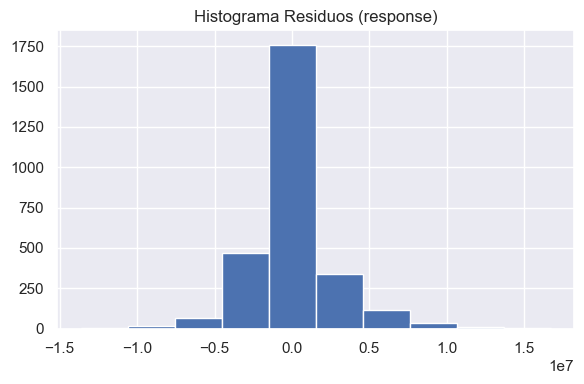

In [193]:
# Histograma errores
plt.figure(figsize=(6, 4))
plt.hist(model_glm.resid_response)
plt.title("Histograma Residuos (response)")
plt.tight_layout()
plt.show()

### Prueba

In [201]:
pred = model_glm.get_prediction(X_test).summary_frame(alpha=0.05)

y = y_test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

comp = pd.concat([ y.rename("Real"), pred], axis=1)
comp.columns = ['Real', 'Predicción', 'Desv. Est.', 'Inf. 0.025', 'Sup. 0.975']
comp['Diferencia'] = comp['Real'] - comp['Predicción']
comp.head()

Real    Predicción    Desv. Est.    Inf. 0.025    Sup. 0.975  \
0  14864305.82  8.250754e+06  2.228908e+05  7.825259e+06  8.699384e+06   
1  12885453.38  1.720849e+07  1.027259e+06  1.530842e+07  1.934440e+07   
2   5628636.60  4.601029e+06  2.644137e+05  4.110909e+06  5.149584e+06   
3   3765624.01  4.577324e+06  1.812734e+05  4.235473e+06  4.946766e+06   
4   1337787.47  2.031709e+06  5.742354e+04  1.922222e+06  2.147433e+06   

     Diferencia  
0  6.613552e+06  
1 -4.323037e+06  
2  1.027607e+06  
3 -8.116998e+05  
4 -6.939217e+05

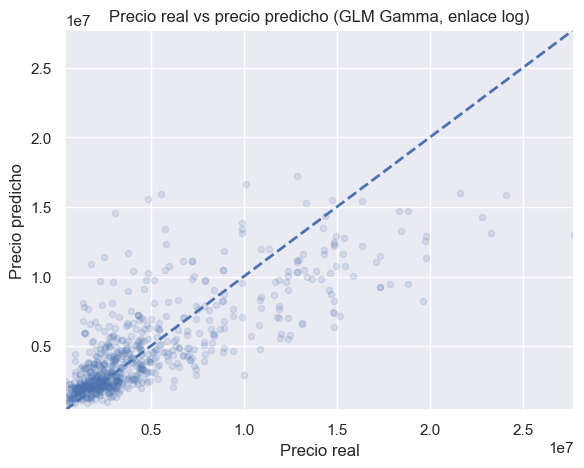

In [203]:
plt.figure(figsize=(6, 5))

plt.scatter(
    comp['Real'],
    comp['Predicción'],
    alpha=0.15,
    s=20
)

# Línea 45°
lims = [
    min(comp['Real'].min(), comp['Predicción'].min()),
    max(comp['Real'].max(), comp['Predicción'].max())
]

plt.plot(lims, lims, linestyle='--', linewidth=2)

plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Precio real vs precio predicho (GLM Gamma, enlace log)")

plt.tight_layout()
plt.show()


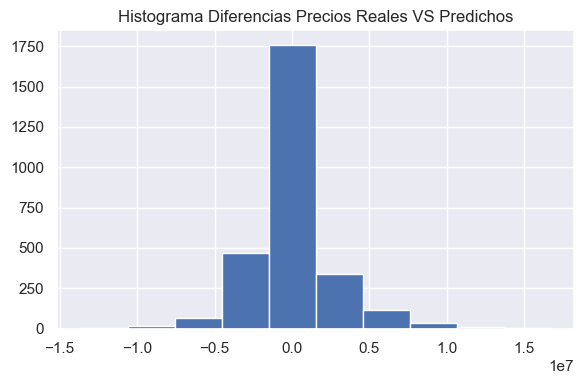

In [205]:
# Histograma Diferencias Predicción y Precios reales
plt.figure(figsize=(6, 4))
plt.hist(model_glm.resid_response)
plt.title("Histograma Diferencias Precios Reales VS Predichos")
plt.tight_layout()
plt.show()

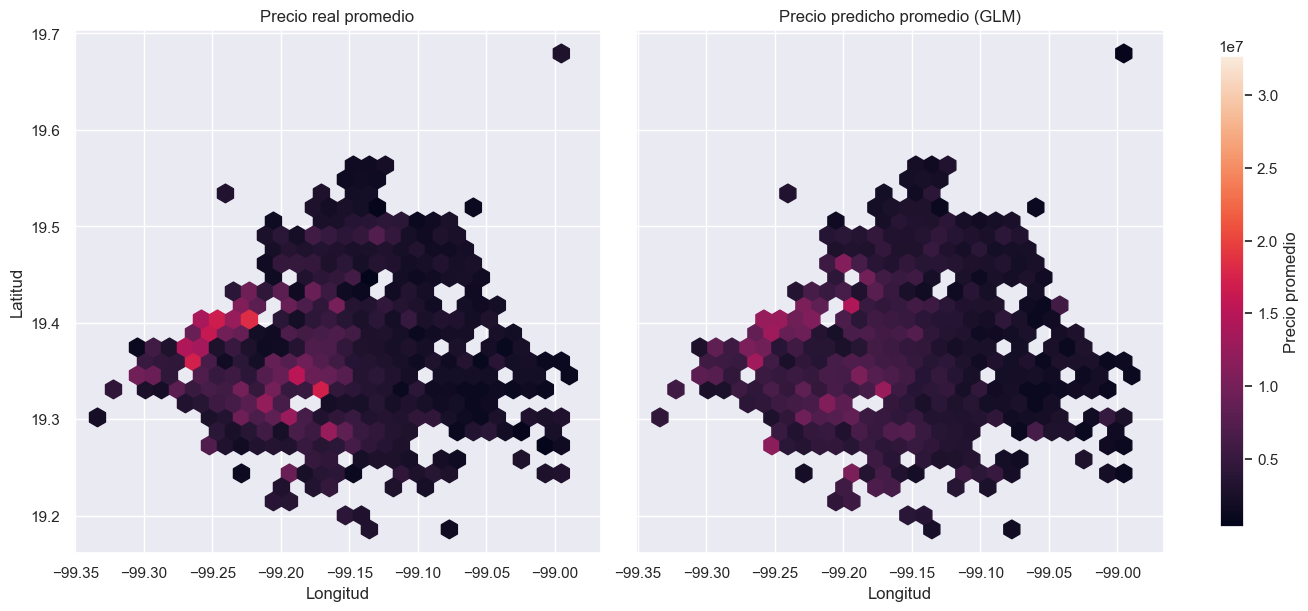

In [256]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(13, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True
)

# Precio real
hb1 = axes[0].hexbin(
    data.longitud,
    data.latitud,
    C=data.precio,
    reduce_C_function=np.mean,
    gridsize=30,
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("Precio real promedio")
axes[0].set_xlabel("Longitud")
axes[0].set_ylabel("Latitud")

# Precio predicho
hb2 = axes[1].hexbin(
    data.longitud,
    data.latitud,
    C=pr,
    reduce_C_function=np.mean,
    gridsize=30,
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title("Precio predicho promedio (GLM)")
axes[1].set_xlabel("Longitud")

# Colorbar común
cbar = fig.colorbar(hb2, ax=axes, shrink=0.9)
cbar.set_label("Precio promedio")

plt.show()


## Conclusión

El modelo de Regresión Lineal Generalizada (GLM) con distribución Gamma y enlace logarítmico resulta adecuado para la valuación inmobiliaria, ya que permite modelar una variable estrictamente positiva como el precio y capturar relaciones no lineales y efectos espaciales de forma consistente.

Los resultados muestran que la ubicación es uno de los principales determinantes del precio: varias alcaldías presentan incrementos porcentuales significativos respecto a la categoría de referencia, aun controlando por tamaño y localización geográfica. Asimismo, la variable construcción en m² tiene un efecto positivo y estadísticamente significativo, mientras que los términos cuadráticos confirman la presencia de rendimientos marginales decrecientes y gradientes espaciales complejos.

A pesar de no contar con variables relevantes del sector, como la edad del inmueble o su estado de conservación, el modelo ofrece una estructura interpretable, coherente con la teoría de valuación inmobiliaria y útil para la predicción de precios. En este sentido, constituye una herramienta sólida para apoyar procesos de valuación, análisis comparativo entre zonas y la generación de estimaciones de mercado basadas en datos.

## Anexos

### Datos influyentes

In [211]:
infl = model_glm.get_influence()

diag = pd.DataFrame({
    'cooks_d': infl.cooks_distance[0],
    'leverage': infl.hat_matrix_diag
})

n = model_glm.nobs
p = model_glm.df_model + 1
diag['cooks_flag'] = diag['cooks_d'] > 4/n
diag['leverage_flag'] = diag['leverage'] > 2*p/n

influyentes = diag[
    (diag['cooks_flag']) |
    (diag['leverage_flag'])
]
influyentes[(influyentes.cooks_flag == 1) & (influyentes.leverage_flag ==1)]

cooks_d  leverage  cooks_flag  leverage_flag
45    0.003295  0.540753        True           True
71    0.001990  0.016318        True           True
104   0.004382  0.020598        True           True
119   0.008425  0.029125        True           True
140   0.004342  0.021556        True           True
...        ...       ...         ...            ...
2693  0.003476  0.017759        True           True
2732  0.002361  0.018522        True           True
2762  0.001503  0.024920        True           True
2763  0.003474  0.046116        True           True
2809  0.007589  0.019841        True           True

[92 rows x 4 columns]

### Mapa

In [224]:
import folium
import numpy as np
import pandas as pd
from branca.colormap import linear

# Centro del mapa
lat_c = data.latitud.mean()
lon_c = data.longitud.mean()

m = folium.Map(location=[lat_c, lon_c], zoom_start=12)

# Escala de color (precio)
colormap = linear.YlOrRd_09.scale(
    data.precio.min(),
    data.precio.max()
)
colormap.caption = 'Precio'

for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row.latitud, row.longitud],
        radius=4,
        fill=True,
        fill_opacity=0.6,
        color=colormap(row.precio),
        popup=f"Precio: ${row.precio:,.0f}"
    ).add_to(m)

colormap.add_to(m)
m
